# MACFAC

## Importing Packages

In [1]:
from mlots.models import kNNClassifier
from sklearn.model_selection import GridSearchCV
from scipy.io import arff
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from sklearn.metrics import accuracy_score
warnings.filterwarnings("ignore")
import matplotlib
import time
%matplotlib inline

In [2]:
font = {'size'   : 22}

matplotlib.rc('font', **font)

## Loading Data

Here we are loading the ``PickupGestureWiimoteZ`` dataset.  
The datasets are in two ``.arff`` files with pre-defined train and test splits.  
The following code reads the two files stores the ``X`` (time-series data) and ``y`` (labels), into their specific train and test sets.
***

In [3]:
name = "PickupGestureWiimoteZ"

dataset = arff.loadarff(f'../input/{name}/{name}_TRAIN.arff'.format(name=name))[0]
X_train = np.array(dataset.tolist(), dtype=np.float32)
y_train = X_train[: , -1]
X_train = X_train[:, :-1]

dataset = arff.loadarff(f'../input/{name}/{name}_TEST.arff'.format(name=name))[0]
X_test = np.array(dataset.tolist(), dtype=np.float32)
y_test = X_test[: , -1]
X_test = X_test[:, :-1]

#Converting target from bytes to integer
y_train = [int.from_bytes(el, "little") for el in y_train]
y_test = [int.from_bytes(el, "little") for el in y_test]

#Filling NaN/missing values with 0.0
X_train = np.nan_to_num(X_train, 0.0)
X_test = np.nan_to_num(X_test, 0.0)

X_train.shape, X_test.shape

((50, 361), (50, 361))

|Set|Sample size|TS length|
|:---|:----------|:-------|
|Train|50|361|
|Test|50|361|

## Evaluating kNNClassifier for full-k-NN-DTW

### Model tuning

``kNNClassifier`` model allows us to work with a more complex distance measure like ``DTW`` in with or without ``MAC/FAC`` strategy.  
Here, we would use ``GridSearchCV`` algorithm from the ``sklearn`` package to find the best set of parameters of the model over the dataset.  
The model tuning would be done **only** over the ``train`` set of the dataset.
***

In [8]:
#Setting up the warping window grid of the DTW measure

dtw_params = []
for w_win in range(5,10,3):
    dtw_params.append(
    {
        "global_constraint": "sakoe_chiba",
        "sakoe_chiba_radius": w_win
    }
    )
dtw_params

[{'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 5},
 {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 8}]

In [9]:
#Setting up the param grid for the kNNClassifier model with the DTW params

param_grid = {
    "n_neighbors": np.arange(1,10,2),
    "metric_params" : dtw_params
}
param_grid

{'n_neighbors': array([1, 3, 5, 7, 9]),
 'metric_params': [{'global_constraint': 'sakoe_chiba',
   'sakoe_chiba_radius': 5},
  {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 8}]}

In [ ]:
#Executing the GridSearchCv over the kNNClassifier model with the supplied param_grid.

model = kNNClassifier(mac_metric="dtw")
gscv = GridSearchCV(model, param_grid=param_grid, cv=5,
                    scoring="accuracy", n_jobs=-1).fit(X_train,y_train)

In [8]:
#Displaying the best parameters of kNNClassifier within the search grid.

best_param = gscv.best_params_
best_score = gscv.best_score_
print("Best Parameters: ", best_param)
print("Best Accuracy: ", best_score)

Best Parameters:  {'metric_params': {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 5}, 'n_neighbors': 1}
Best Accuracy:  0.62


### Evaluation of tuned model

The parameters displayed above are optimal set of parameters for the ``kNNClassifier`` model over ``PickupGestureWiimoteZ`` dataset.  
Our next task is then to train the ``kNNClassifier`` model over the ``train`` set with the optimal set of parameters, and evaluate the model over the held-out ``test`` set.
***

In [10]:
start = time.time()
model = kNNClassifier(**best_param,mac_metric="dtw",
                           n_jobs=1).fit(X_train,y_train)

y_hat = model.predict(X_test)
acc = accuracy_score(y_test, y_hat)
end = time.time()
elapsed = end-start

In [127]:
print("Model Accuracy: ", round(acc, 2))
print("Time: ", round(elapsed, 2))

Model Accuracy:  0.7
Time:  12.75


We achieve an accuracy of 70% by full k-NN-DTW model. The model takes 12.75 $s$ to complete the task.

## Using MAC/FAC Strategy

Here we would look into speeding up the classification of the kNNClassifer model by using the MAC/FAC strategy.  
The classification would happen in two stages:
- MAC stage: The model retrieves a candidate subset of size ``mac_neighbors`` using the ``mac_metric``.
- FAC stage: The model retrieves the closest ``n_neighbors`` from the candidates set using ``DTW``, and consider them for prediction/classification.

***

### Model tuning

In [11]:
param_grid = {
    "n_neighbors": np.arange(1,6,2),
    "mac_neighbors": np.arange(20,40,5)
}
param_grid

{'n_neighbors': array([1, 3, 5]), 'mac_neighbors': array([20, 25, 30, 35])}

In [15]:
#We use the the same metric_params as supplied to previous model, for fair analysis.
metric_params = {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 5}

model = kNNClassifier(mac_metric="euclidean",
                     metric_params=metric_params)
gscv_mf = GridSearchCV(model, param_grid=param_grid, cv=5,
                    scoring="accuracy", n_jobs=-1).fit(X_train,y_train)

In [17]:
#Displaying the best parameters of kNNClassifier within the search grid.

best_param_mf = gscv_mf.best_params_
best_score_mf = gscv_mf.best_score_
print("Best Parameters: ", best_param_mf)
print("Best Accuracy: ", best_score_mf)

Best Parameters:  {'mac_neighbors': 20, 'n_neighbors': 1}
Best Accuracy:  0.7


### Evaluation of tuned model

In [46]:
start = time.time()
model_mf = kNNClassifier(**best_param_mf,mac_metric="euclidean",
                           metric_params=metric_params, n_jobs=1).fit(X_train,y_train)

y_hat_mf = model_mf.predict(X_test)
acc_mf = accuracy_score(y_test, y_hat_mf)
end = time.time()
elapsed_mf = end-start

In [47]:
print("Model Accuracy: ", round(acc_mf, 2))
print("Retrieval Time: ", round(elapsed_mf, 2))

Model Accuracy:  0.7
Retrieval Time:  0.93


kNNClassifer w/ MAC/FAC strategy achieves the **same classification accuracy** of full-kNN-DTW. However, the model is **10 times faster** than the previous one.

## Comparison

Here we do bar-plot that would illustrate the performance of the ``kNNClassifier`` model with **default** parameters against the model with the **tuned** parameters.  
The ``matplotlib.pyplot`` is employed for this task.
***

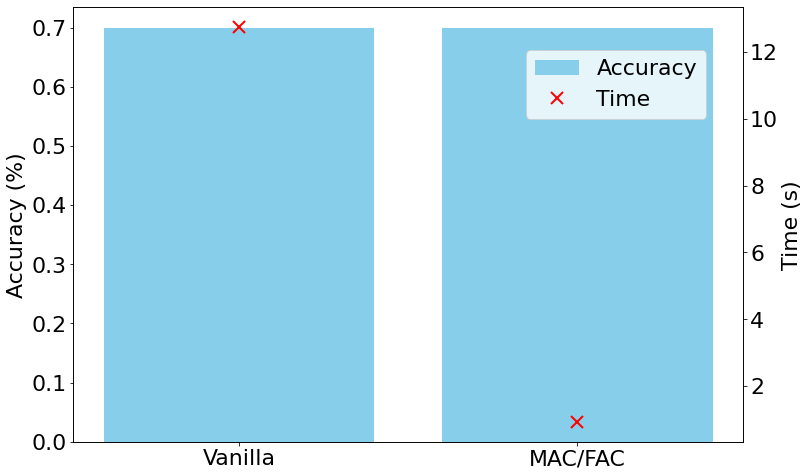

In [126]:
models = ["Vanilla", "MAC/FAC"]
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.bar(models, [acc,acc_mf], color="skyblue", label="Accuracy")
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(),
         [elapsed,elapsed_mf],
         color='r',
         markersize=12,
         marker="x",
         mew=2,
         linewidth=0, label="Time")
fig.legend(loc=(0.65,0.75))
ax.set_ylabel('Accuracy (%)')
ax2.set_ylabel('Time (s)')
plt.show()